# Noise2Void Experiment

[CVPR 2019 : Noise2Void - Learning Denoising from Single Noisy Image](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf)

Key idea: 
- Blind-spot network(BSN), network learn the mapping between mask pixel(s) and every other pixels
- the expect of output identical to clean image when noise mean is zero and i.i.d and there traing data inf.

Pros: 
1. single noisy image denoising, has tremendous practicality on medical denoising task
2. can adaptive to any noise distribution since its learn denoising directly from noisy image 

Cons:
1. by masking certain pixel(s), the quality of denoising decrease, especially for high-frequency content
2. strong assumption of zero mean noise and pixels i.i.d, leading to poor performance when it dealing with structured noise 
3. denoising performance slightly degrade to N2N but still better than BM3D

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom

from module.models import UNet2_5D
from module.datasets import Mask2_5Dataset


import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


## Load noisy dataset

Noisy data...float64 (shape:(24, 71, 192, 192); range:[-0.018414393986850297,1.0298518324719883]; mean:0.5030665574527993); std:0.02335746313650884
b'{"mean": 201.12048776036573, "std": 1412.4139804758772, "min": -23.34168377224119, "max": 23.05689405684542}'


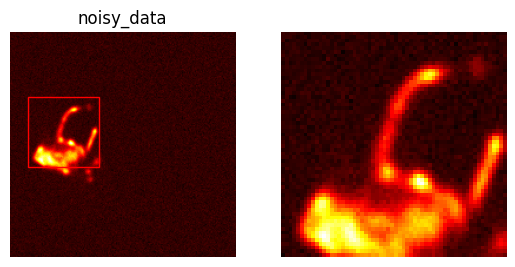

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_gauss_0.009.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = f['restore_info'][...]
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)
display_image_in_detail(noisy_data[11, 38], title='noisy_data')

## Process Denoising

## 1. define denoising network

In [3]:

model = UNet2_5D(in_channels=1, out_channels=1)
model = model.to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

summary(model, [(1, 192, 192), (1, 192, 192), (1, 192, 192)])

The number of parameters of the network is:  138372097
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           1,792
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
            Conv2d-4         [-1, 64, 192, 192]          36,928
       BatchNorm2d-5         [-1, 64, 192, 192]             128
            Conv2d-6         [-1, 64, 192, 192]             256
              ReLU-7         [-1, 64, 192, 192]               0
         UNetBlock-8         [-1, 64, 192, 192]               0
         MaxPool2d-9           [-1, 64, 96, 96]               0
           Conv2d-10          [-1, 128, 96, 96]          73,856
      BatchNorm2d-11          [-1, 128, 96, 96]             256
             ReLU-12          [-1, 128, 96, 96]               0
           Conv2d-13          [-1, 128, 96, 96] 

## 2. create mask dataset and dataloader

In [4]:

noisy_tensor = torch.tensor(noisy_data[:, np.newaxis, :, :, :], dtype=torch.float32)
noisy_tensor = noisy_tensor.to(device)
print(f"noisy_tensor shape: {noisy_tensor.shape}")

noisy_dataset = Mask2_5Dataset(noisy_tensor, apply_mask=True, n_mask=1)
noisy_dataloader = DataLoader(noisy_dataset, batch_size=4, shuffle=True)

noisy_tensor shape: torch.Size([24, 1, 71, 192, 192])


Top slice shape: torch.Size([4, 1, 192, 192])
Middle slice shape: torch.Size([4, 1, 192, 192])
Bottom slice shape: torch.Size([4, 1, 192, 192])
mask_middle shape: torch.Size([4, 1, 192, 192]); num of count<1.0: 4; mean: 0.9999728798866272


Text(0.5, 1.0, 'x_bottom')

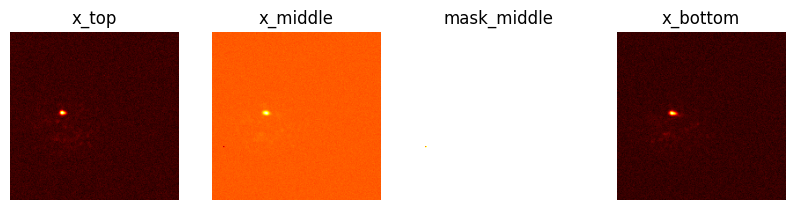

In [5]:
# example data batch

noisy_data_iterator = iter(noisy_dataloader)
x_top, x_middle, x_bottom, mask_middle = next(noisy_data_iterator)
print("Top slice shape:", x_top.shape)
print("Middle slice shape:", x_middle.shape)
print("Bottom slice shape:", x_bottom.shape)
print(f"mask_middle shape: {mask_middle.shape}; num of count<1.0: {torch.sum(mask_middle < torch.mean(mask_middle)).item()}; mean: {torch.mean(mask_middle)}")


# example batch display
example_batch_num = 0
example_batch_num = min(example_batch_num, x_middle.shape[0] - 1)

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(x_top.cpu()[example_batch_num, 0], cmap='hot')
axs[0].axis('off')
axs[0].set_title("x_top")
axs[1].imshow(x_middle.cpu()[example_batch_num, 0], cmap='hot')
axs[1].axis('off')
axs[1].set_title("x_middle")
axs[2].imshow(mask_middle.cpu()[example_batch_num, 0], cmap='hot')
axs[2].axis('off')
axs[2].set_title("mask_middle")
axs[3].imshow(x_bottom.cpu()[example_batch_num, 0], cmap='hot')
axs[3].axis('off')
axs[3].set_title("x_bottom")

## 3.  define training modules

In [9]:
@timer_decorator
def train(model, noisy_dataloader, criterion, optimizer, num_epochs, save_path, patience=5, lr_step_size=10, lr_gamma=0.7):
    model.train()
    min_loss = float('inf')
    best_epoch = -1
    no_improvement = 0

    # gamma learning rate scheudle
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

    for epoch in range(num_epochs):
        running_loss = 0.0
        num_batches = 0

        progress_bar = tqdm(noisy_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True)

        for batch in progress_bar:
            x_top, x_middle, x_bottom, mask_middle = batch
            optimizer.zero_grad()
            outputs = model(x_top, x_middle, x_bottom)
            loss = criterion(outputs, x_middle)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            running_loss += batch_loss
            num_batches += 1

            progress_bar.set_postfix({'Batch Loss': batch_loss}, refresh=True)

        average_loss = running_loss / num_batches
        scheduler.step() # update learning rate 

        # save minimal loss model
        if average_loss < min_loss:
            min_loss = average_loss
            best_epoch = epoch + 1
            best_model_path = os.path.join(save_path, f'best_model_epoch_{best_epoch}.pth')
            torch.save(model.state_dict(), best_model_path)
            no_improvement = 0
        else:
            no_improvement += 1

        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {average_loss:.4f} - Learning Rate: {scheduler.get_last_lr()[0]}')

        # early stopping if no patience left 
        if no_improvement >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            break

    print(f'Training complete. Best model saved at {best_model_path} (Epoch {best_epoch})')





def denoising(model, noisy_tensor, batch_size=32):
    # 1. Prepare the DataLoader
    dataset = Mask2_5Dataset(noisy_tensor, apply_mask=False)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # 2. Set the model to evaluation mode
    model.eval()

    # 3. Pass data through the model and collect outputs
    denoised_slices = []

    with torch.no_grad():
        for x_top, x_middle, x_bottom, _ in dataloader:
            outputs = model(x_top, x_middle, x_bottom)
            denoised_slices.append(outputs)

    # Concatenate all the output slices to create the denoised tensor
    denoised_tensor = torch.cat(denoised_slices, dim=2)

    return denoised_tensor


In [7]:
# hyper parameters 
lr_val = 1e-3
num_epochs = 50

# define loss function
criterion = nn.L1Loss()

# define optimizer 
optimizer = optim.Adam(model.parameters(), lr=lr_val)

## 4. process training

In [10]:
train(model, noisy_dataloader, criterion, optimizer, num_epochs, save_path='./check_points', patience=5, lr_step_size=10, lr_gamma=0.7)

Epoch 1/50:   0%|          | 0/414 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 5. process denoising

## 6. metrics evaluation

# Save denormalized denoised data into 16-bit DICOM files

In [ ]:
# denormalized denoised result
mean_val = 201.12048776036573
std_val = 1412.4139804758772
min_val = -23.34168377224119
max_val = 23.05689405684542

denormalized_denoised_data = denoised_data * (max_val - min_val) + min_val
denormalized_denoised_data = denormalized_denoised_data * std_val + mean_val

denormalized_denoised_data = np.clip(denormalized_denoised_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)


print(f"denormalized_denoised_data: dtype:{denormalized_denoised_data.dtype} range({np.min(denormalized_denoised_data)},{np.max(denormalized_denoised_data)}) mean:{np.mean(denormalized_denoised_data)} std:{np.std(denormalized_denoised_data)}")

display_image_in_detail(denormalized_denoised_data[11, 38])

In [ ]:
# save as dicom files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'
output_folder = './dataset/denoised/N2V/PT_20p 150_120 OSEM_gauss_0.009'

save_4d_dicom(origin_dicom_folder, denormalized_denoised_data, output_folder)